# Experiment 1: Optimize AUROC using AUCMLoss + PESG

In [1]:
# install libauc
!pip install -U libauc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.2 MB/s eta 0:00:00


In [2]:
# import required libraries
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler

# set seed and device
def set_all_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# dataset class with augmentation
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((crop_size, crop_size)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((image_size, image_size))
        ])
        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size))
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, self.targets[idx], idx


In [4]:
# helpers for eval + plotting
from libauc.metrics import auc_roc_score, auc_prc_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_metrics(model, loader, device):
    # returns (auroc, auprc) on a loader
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            # supports (data, target) or (data, target, idx)
            data, target = batch[0], batch[1]
            data = data.to(device)
            out = torch.sigmoid(model(data)).cpu().numpy()
            preds.append(out)
            labels.append(target.numpy())
    y_true = np.concatenate(labels); y_pred = np.concatenate(preds)
    auroc = auc_roc_score(y_true, y_pred)
    auprc = auc_prc_score(y_true, y_pred)
    model.train()
    return auroc, auprc

def plot_metric_curve(iters, vals, y_label, title):
    plt.figure()
    plt.plot(iters, vals)
    plt.xlabel("iteration")
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


In [5]:
# load and imbalance cifar10
train_data, train_targets = CIFAR10(root='./data', train=True).as_array()
test_data, test_targets  = CIFAR10(root='./data', train=False).as_array()

generator = ImbalancedDataGenerator(verbose=True, random_seed=2023)
train_images, train_labels = generator.transform(train_data, train_targets, imratio=0.02)
test_images, test_labels = generator.transform(test_data, test_targets, imratio=0.5)

trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')



100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Files already downloaded and verified
#SAMPLES: 25510, CLASS 0.0 COUNT: 25000, CLASS RATIO: 0.9800
#SAMPLES: 25510, CLASS 1.0 COUNT: 510, CLASS RATIO: 0.0200
#SAMPLES: 10000, CLASS 0.0 COUNT: 5000, CLASS RATIO: 0.5000
#SAMPLES: 10000, CLASS 1.0 COUNT: 5000, CLASS RATIO: 0.5000


In [6]:
from libauc.models import resnet20 as ResNet
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.metrics import auc_roc_score

BATCH_SIZE = 128
lr = 0.1
margin = 1.0
epoch_decay = 0.003
weight_decay = 1e-4
total_epochs = 30
decay_epochs = [15, 25]

model = ResNet(pretrained=False, last_activation=None, num_classes=1).to(device)
loss_fn = AUCMLoss()
optimizer = PESG(model.parameters(), loss_fn=loss_fn, lr=lr,
                 margin=margin, epoch_decay=epoch_decay, weight_decay=weight_decay)

sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=0.2)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False)

[it 200] auroc: 0.6484
[it 400] auroc: 0.6636
[it 600] auroc: 0.6943
[it 800] auroc: 0.6497
[it 1000] auroc: 0.7124
[it 1200] auroc: 0.6996
[it 1400] auroc: 0.6259
[it 1600] auroc: 0.7208
[it 1800] auroc: 0.7331
[it 2000] auroc: 0.7227
[it 2200] auroc: 0.7293
[it 2400] auroc: 0.7097
[it 2600] auroc: 0.7417
[it 2800] auroc: 0.7353
[it 3000] auroc: 0.7212
[it 3200] auroc: 0.6947
[it 3400] auroc: 0.7194
[it 3600] auroc: 0.7393
Reducing learning rate to 0.01000 @ T=3630!
Updating regularizer @ T=3630!
[it 3800] auroc: 0.7630
[it 4000] auroc: 0.7625
[it 4200] auroc: 0.7604
[it 4400] auroc: 0.7599
[it 4600] auroc: 0.7573
[it 4800] auroc: 0.7567
[it 5000] auroc: 0.7543
[it 5200] auroc: 0.7557
[it 5400] auroc: 0.7563
[it 5600] auroc: 0.7536
[it 5800] auroc: 0.7542
[it 6000] auroc: 0.7550
Reducing learning rate to 0.00100 @ T=6050!
Updating regularizer @ T=6050!
[it 6200] auroc: 0.7532
[it 6400] auroc: 0.7533
[it 6600] auroc: 0.7524
[it 6800] auroc: 0.7521
[it 7000] auroc: 0.7515
[it 7200] auro

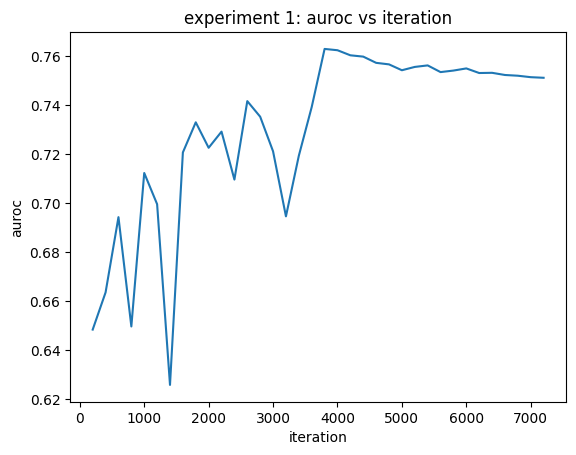

In [7]:
# train and evaluate auroc (per-iteration logging + plot)
# logging setup for experiment 1
eval_every = 200
iter_idx_1, auroc_vals_1 = [], []
global_step_1 = 0

for epoch in range(total_epochs):
    if epoch in decay_epochs:
        optimizer.update_regularizer(decay_factor=10)

    model.train()  # ensure training mode
    for data, targets, _ in trainloader:  # dataset returns (image, target, idx)
        data, targets = data.to(device), targets.to(device)

        y_pred = torch.sigmoid(model(data))
        loss = loss_fn(y_pred, targets)  # aucmloss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per-iteration eval + log
        global_step_1 += 1
        if global_step_1 % eval_every == 0:
            auroc, _ = evaluate_metrics(model, testloader, device)
            iter_idx_1.append(global_step_1)
            auroc_vals_1.append(auroc)
            print(f"[it {global_step_1}] auroc: {auroc:.4f}")

# plot auroc vs iteration
plot_metric_curve(iter_idx_1, auroc_vals_1, "auroc", "experiment 1: auroc vs iteration")

In [8]:
# Experiment 2: Optimize AUPRC using APLoss + SOAP

In [9]:
from libauc.models import resnet18 as ResNet
from libauc.losses import APLoss
from libauc.optimizers import SOAP
from libauc.metrics import auc_prc_score

BATCH_SIZE = 64
lr = 1e-3
margin = 0.6
gamma = 0.1
weight_decay = 2e-4
total_epochs = 30
decay_epochs = [15, 25]

model = ResNet(pretrained=False, last_activation=None, num_classes=1).to(device)
loss_fn = APLoss(data_len=len(trainSet), margin=margin, gamma=gamma)
optimizer = SOAP(model.parameters(), lr=lr, mode='adam', weight_decay=weight_decay)

sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=0.5)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False)

[it 200] auprc: 0.6067
[it 400] auprc: 0.6353
[it 600] auprc: 0.6301
[it 800] auprc: 0.6609
[it 1000] auprc: 0.5968
[it 1200] auprc: 0.6884
[it 1400] auprc: 0.6937
[it 1600] auprc: 0.6974
[it 1800] auprc: 0.7128
[it 2000] auprc: 0.7139
[it 2200] auprc: 0.7333
[it 2400] auprc: 0.7195
[it 2600] auprc: 0.7272
[it 2800] auprc: 0.7362
[it 3000] auprc: 0.7380
[it 3200] auprc: 0.7349
[it 3400] auprc: 0.7326
[it 3600] auprc: 0.6687
[it 3800] auprc: 0.7199
[it 4000] auprc: 0.7234
[it 4200] auprc: 0.7189
[it 4400] auprc: 0.7381
[it 4600] auprc: 0.7210
[it 4800] auprc: 0.7322
[it 5000] auprc: 0.7343
[it 5200] auprc: 0.7283
[it 5400] auprc: 0.7285
[it 5600] auprc: 0.7209
[it 5800] auprc: 0.7336
[it 6000] auprc: 0.7178
[it 6200] auprc: 0.6898
[it 6400] auprc: 0.7253
[it 6600] auprc: 0.7121
[it 6800] auprc: 0.7328
[it 7000] auprc: 0.7164
[it 7200] auprc: 0.7203
[it 7400] auprc: 0.7172
[it 7600] auprc: 0.7308
[it 7800] auprc: 0.7212
[it 8000] auprc: 0.7172
[it 8200] auprc: 0.7162
[it 8400] auprc: 0.7

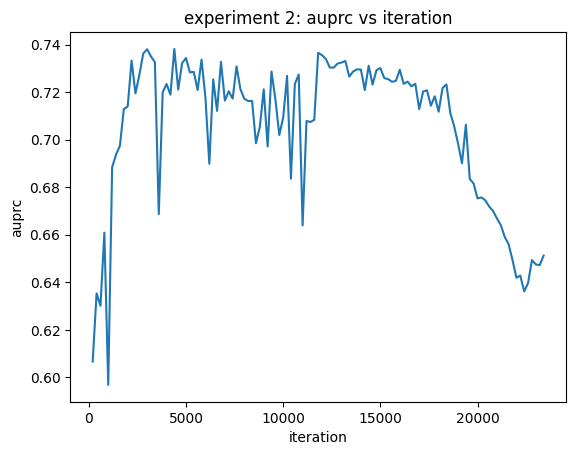

In [10]:
# train and evaluate auprc (per-iteration logging + plot)
eval_every = 200
iter_idx_2, auprc_vals_2 = [], []
global_step_2 = 0

for epoch in range(total_epochs):
    if epoch in decay_epochs:
        optimizer.update_lr(decay_factor=10)  # soap supports this

    model.train()  # make sure we're in train mode
    for data, targets, idx in trainloader:
        data, targets, idx = data.to(device), targets.to(device), idx.to(device)

        # skip batches with no positives (aploss needs positives)
        if (targets == 1).sum() == 0:
            continue

        y_prob = torch.sigmoid(model(data))
        loss = loss_fn(y_prob, targets, idx)  # loss_fn should be APLoss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per-iteration eval + log
        global_step_2 += 1
        if global_step_2 % eval_every == 0:
            _, auprc = evaluate_metrics(model, testloader, device)
            iter_idx_2.append(global_step_2)
            auprc_vals_2.append(auprc)
            print(f"[it {global_step_2}] auprc: {auprc:.4f}")

# plot auprc vs iteration
plot_metric_curve(iter_idx_2, auprc_vals_2, "auprc", "experiment 2: auprc vs iteration")

In [11]:
# 🔬 Experiment 3: Combine AUROC + AUPRC with r-weighted loss

In [12]:
# projection onto omega: clamp to [0,1], then normalize to sum=1
def project_to_omega(lmbd: torch.Tensor) -> torch.Tensor:
    lmbd = torch.clamp(lmbd, min=0.0, max=1.0)
    s = lmbd.sum()
    if s <= 0:
        lmbd = torch.ones_like(lmbd) / lmbd.numel()
    else:
        lmbd = lmbd / s
    return lmbd

In [13]:
from libauc.losses import AUCMLoss, APLoss
from torch.optim import Adam
from libauc.sampler import DualSampler

r = 0.5  # try 0.2, 0.5, 0.8
model = ResNet(pretrained=False, last_activation=None, num_classes=1).to(device)
loss_ap = APLoss(data_len=len(trainSet), margin=0.6, gamma=0.1)
loss_auc = AUCMLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

sampler = DualSampler(trainSet, batch_size=64, sampling_rate=0.5)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=sampler)
testloader  = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

[it 200] auroc=0.5863 | auprc=0.5942  lambda=[0.2267756164073944, 0.773224413394928]
[it 400] auroc=0.6258 | auprc=0.6171  lambda=[0.206780806183815, 0.7932192087173462]
[it 600] auroc=0.6363 | auprc=0.6333  lambda=[0.1479790359735489, 0.8520209789276123]
[it 800] auroc=0.6424 | auprc=0.6412  lambda=[0.11770821362733841, 0.8822917938232422]
[it 1000] auroc=0.6536 | auprc=0.6500  lambda=[0.10814743489027023, 0.891852617263794]
[it 1200] auroc=0.6658 | auprc=0.6660  lambda=[0.08888019621372223, 0.911119818687439]
[it 1400] auroc=0.6785 | auprc=0.6718  lambda=[0.07973001897335052, 0.9202699661254883]
[it 1600] auroc=0.6877 | auprc=0.6771  lambda=[0.06676778942346573, 0.9332321882247925]
[it 1800] auroc=0.6817 | auprc=0.6729  lambda=[0.06570896506309509, 0.9342910647392273]
[it 2000] auroc=0.6813 | auprc=0.6769  lambda=[0.057917140424251556, 0.9420828223228455]
[it 2200] auroc=0.6925 | auprc=0.6833  lambda=[0.057737551629543304, 0.9422624707221985]
[it 2400] auroc=0.6934 | auprc=0.6898  la

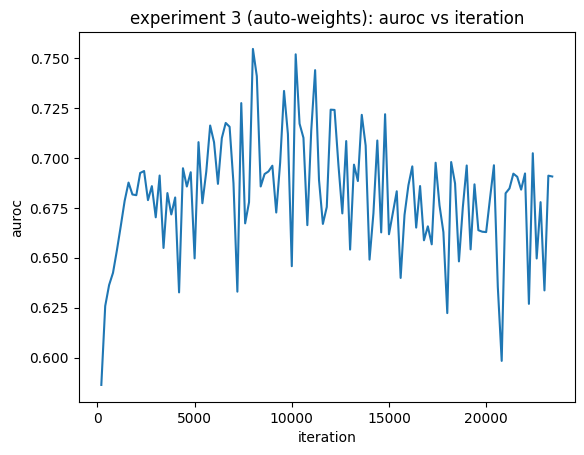

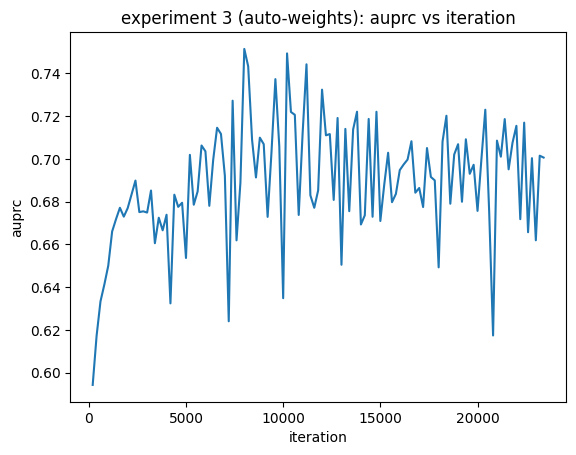

In [14]:
# train and evaluate combined loss (auto-weights λ) + print auroc+auprc + plot curves
from libauc.losses import AUCMLoss, APLoss
from torch.optim import Adam
from libauc.sampler import DualSampler

# projection onto omega: clamp to [0,1], then normalize to sum=1
# (safe to redefine; if you already defined it earlier you can remove this copy)
def project_to_omega(lmbd: torch.Tensor) -> torch.Tensor:
    # clamp each element to [0,1]
    lmbd = torch.clamp(lmbd, min=0.0, max=1.0)
    # normalize to sum to 1 (fallback to uniform if sum is 0)
    s = lmbd.sum()
    if s <= 0:
        lmbd = torch.ones_like(lmbd) / lmbd.numel()
    else:
        lmbd = lmbd / s
    return lmbd

# model, device already defined earlier
loss_ap  = APLoss(data_len=len(trainSet), margin=0.6, gamma=0.1)
loss_auc = AUCMLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# use dualsampler so every batch has positives
sampler = DualSampler(trainSet, batch_size=64, sampling_rate=0.5)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=sampler)
testloader  = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

# initialize lambda = [weight_ap, weight_auc]
lmbd = torch.tensor([0.5, 0.5], device=device)
eta_lambda = 0.1  # try 0.05–0.2 if it oscillates

# logging setup
eval_every = 200
iter_idx, auroc_log, auprc_log, w_log = [], [], [], []
global_step = 0
epochs = 30

for epoch in range(epochs):
    model.train()
    for data, targets, idx in trainloader:
        data, targets, idx = data.to(device), targets.to(device), idx.to(device)

        # skip no-positive batches (required by both losses)
        if (targets == 1).sum() == 0:
            continue

        # forward
        out = torch.sigmoid(model(data))

        # individual objectives
        loss_ap_val  = loss_ap(out, targets, idx)
        loss_auc_val = loss_auc(out, targets)

        # combined objective with current lambda
        loss = lmbd[0] * loss_ap_val + lmbd[1] * loss_auc_val

        # minimize over x (model params)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # maximize over λ then project to Ω (clip + normalize)
        with torch.no_grad():
            # make a 2-vector with matching shape/device using .item()
            grad_lambda = torch.tensor(
                [loss_ap_val.detach().item(), loss_auc_val.detach().item()],
                device=device
            )
            lmbd = lmbd + eta_lambda * grad_lambda
            lmbd = project_to_omega(lmbd)

        # periodic eval + logging
        global_step += 1
        if global_step % eval_every == 0:
            auroc, auprc = evaluate_metrics(model, testloader, device)
            iter_idx.append(global_step)
            auroc_log.append(auroc)
            auprc_log.append(auprc)
            w_log.append(lmbd.detach().cpu().numpy().tolist())
            print(f"[it {global_step}] auroc={auroc:.4f} | auprc={auprc:.4f}  lambda={lmbd.tolist()}")

# plots with requested axis titles
plot_metric_curve(iter_idx, auroc_log, "auroc", "experiment 3 (auto-weights): auroc vs iteration")
plot_metric_curve(iter_idx, auprc_log, "auprc", "experiment 3 (auto-weights): auprc vs iteration")


In [15]:
# auto-tune r over [0,1] to avoid manual picking
from torch.optim import Adam
from libauc.losses import AUCMLoss, APLoss
from libauc.models import resnet18 as ResNetForCombined

def run_combined_for_r(base_model_ctor, r, epochs=5, lr=1e-3, weight_decay=1e-4,
                       sampling_rate=0.5, device=device):
    m = base_model_ctor(pretrained=False, last_activation=None, num_classes=1).to(device)
    opt = Adam(m.parameters(), lr=lr, weight_decay=weight_decay)
    loss_ap  = APLoss(data_len=len(trainSet), margin=0.6, gamma=0.1)
    loss_auc = AUCMLoss()

    sampler = DualSampler(trainSet, batch_size=64, sampling_rate=sampling_rate)
    tl = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=sampler)

    for _ in range(epochs):
        for data, targets, idx in tl:
            data, targets, idx = data.to(device), targets.to(device), idx.to(device)
            if (targets == 1).sum() == 0:
                continue
            out = torch.sigmoid(m(data))
            loss = r * loss_ap(out, targets, idx) + (1 - r) * loss_auc(out, targets)
            opt.zero_grad(); loss.backward(); opt.step()

    return evaluate_metrics(m, testloader, device)  # (auroc, auprc)

def auto_tune_r():
    r_values = np.linspace(0.0, 1.0, 11)  # 0.00..1.00 step 0.10
    results = []
    for rv in r_values:
        auroc, auprc = run_combined_for_r(ResNetForCombined, rv)
        results.append((rv, auroc, auprc))
        print(f"r={rv:.2f} -> auroc={auroc:.4f}, auprc={auprc:.4f}")
    best = max(results, key=lambda x: x[2])  # choose by auprc; change if you prefer auroc
    print(f"\nbest r by auprc = {best[0]:.2f} (auroc={best[1]:.4f}, auprc={best[2]:.4f})")
    return results, best

# run auto-tune if you want
# results, best = auto_tune_r()


In [16]:
# projection onto omega: clamp each element to [0,1], then normalize to sum=1
import torch

def project_to_omega(lmbd: torch.Tensor) -> torch.Tensor:
    # lmbd: 1d tensor, any device
    lmbd = torch.clamp(lmbd, min=0.0, max=1.0)
    s = lmbd.sum()
    if s <= 0:
        # fallback: uniform if everything was clamped to 0
        lmbd = torch.ones_like(lmbd) / lmbd.numel()
    else:
        lmbd = lmbd / s
    return lmbd

# quick sanity checks (linear)
t = torch.tensor([-0.2, 0.3, 1.4, 0.6])
print("before:", t)
print("after :", project_to_omega(t))

before: tensor([-0.2000,  0.3000,  1.4000,  0.6000])
after : tensor([0.0000, 0.1579, 0.5263, 0.3158])


In [17]:
# fill these with your final metrics from the earlier fixed-r runs (or re-run them briefly)
baseline_final_auroc = 0.80  # <-- put your actual number here
baseline_final_auprc = 0.65  # <-- put your actual number here

auto_final_auroc = auroc_log[-1]
auto_final_auprc = auprc_log[-1]

print("baseline vs auto-weights (final metrics)")
print(f"auroc: baseline={baseline_final_auroc:.4f}  auto={auto_final_auroc:.4f}  diff={auto_final_auroc - baseline_final_auroc:+.4f}")
print(f"auprc: baseline={baseline_final_auprc:.4f}  auto={auto_final_auprc:.4f}  diff={auto_final_auprc - baseline_final_auprc:+.4f}")

baseline vs auto-weights (final metrics)
auroc: baseline=0.8000  auto=0.6907  diff=-0.1093
auprc: baseline=0.6500  auto=0.7006  diff=+0.0506
